# Reward hacking

Start by importing dependencies and setting up two clients, one for OpenAI and one for Predibase:

In [1]:
import os
from datasets import load_dataset
from dotenv import load_dotenv
from openai import OpenAI

from utils import *

load_dotenv()

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

pb_client = OpenAI(
    base_url=os.environ["PREDIBASE_MODEL_LLAMA_URL"],
    api_key=os.environ["PREDIBASE_API_KEY"],
)

## Hacking the summarization task with longer summaries

Here, you'll see how longer summaries could lead to higher rewards. Start by loading the same earnings call dataset from the previous lesson:

In [2]:
ds = load_dataset("mrSoul7766/ECTSum")
transcript = ds["train"][1]["text"]

Generate a quiz based on the call:

In [3]:
quiz = generate_quiz(transcript)
print(quiz)


Question 1:
What was the Q1 adjusted diluted earnings per share?
A. $3.34
B. $5.32
C. $2.49
D. $1.00

Question 2:
By what percentage did comparable store sales grow in Q1?
A. 29.4%
B. 15.4%
C. 24.7%
D. 32.1%

Question 3:
What was the adjusted operating income for Q1?
A. $150 million
B. $200 million
C. $299 million
D. $113 million

Question 4:
How much free cash flow did the company generate in Q1?
A. $259 million
B. $203 million
C. $150 million
D. $330 million

Question 5:
What is the expected comp sales growth for the year?
A. 6% to 8%
B. 4% to 6%
C. 5% to 7%
D. 3% to 5%

Question 6:
What was the main driver of category net sales growth in Q1?
A. All of the above
B. Wipers
C. Appearance chemicals
D. Batteries

Question 7:
What is the expected adjusted OI margin range for the year?
A. 7.5% to 8%
B. 9% to 9.2%
C. 9.5% to 10%
D. 8% to 8.5%


Generate 8 summaries of the call (again, you'll use the Llama-3.1-8B-Instruct-dequantized, which is defined in the utils.py file):

In [4]:
prompt = f"""Generate a concise bulleted summary of the 
information in the following earnings call transcript.

Only respond with the summary, do not include any extraneous text.

Transcript:

{transcript}
"""

completions = pb_client.chat.completions.create(
    model=MODEL_NAME,
    messages=[
        {"role": "user", "content": prompt},
    ],
    n=8,
    temperature=0.9,
)

Use each summary to take the quiz and get a reward score:

In [5]:
responses = [choice.message.content for choice in completions.choices]
quiz_rewards = [quiz_reward(resp, quiz) for resp in responses]
quiz_rewards

[0.8571428571428571,
 0.8571428571428571,
 0.7142857142857143,
 0.8571428571428571,
 0.8571428571428571,
 0.7142857142857143,
 0.7142857142857143,
 0.7142857142857143]

The transcript should get a perfect score: check that it does:

In [6]:
transcript_score = quiz_reward(transcript, quiz)
transcript_score

1.0

Check lengths of the 8 summaries and compare to full transcript:

In [7]:
lengths = [len(resp) for resp in responses]
lengths

[1059, 1211, 1347, 1077, 1253, 1482, 1095, 1184]

In [8]:
len(transcript)

21810

## Create a penalty function to discourage longer summaries

Here, you'll create a reward function that assigns a negative score (i.e. a penalty) to the model for longer summaries. Over time during training, this penalty should discourage the model from getting higher quiz scores just by writing longer summaries.

In [9]:
def length_penalty_reward(response: str) -> float:
    length = len(response)
    target_length = 1024
    if length <= target_length:
        return 0.0
    else:
        return max(
            (target_length - length) / target_length,
            -10
        ) 

In [10]:
transcript_reward = length_penalty_reward(transcript)
transcript_reward

-10

Show the length penalties and resulting advantages for the 8 summaries:

In [11]:
lengths = [len(resp) for resp in responses]
length_rewards = [
    length_penalty_reward(resp) for resp in responses
]
print_length_table(lengths, length_rewards)

+---------+----------+------------+-------------+
|   Index |   Length |     Reward |   Advantage |
+=========+==========+============+=============+
|       0 |     1059 | -0.0341797 |    1.13248  |
+---------+----------+------------+-------------+
|       1 |     1211 | -0.182617  |    0.018325 |
+---------+----------+------------+-------------+
|       2 |     1347 | -0.31543   |   -0.978554 |
+---------+----------+------------+-------------+
|       3 |     1077 | -0.0517578 |    1.00054  |
+---------+----------+------------+-------------+
|       4 |     1253 | -0.223633  |   -0.289535 |
+---------+----------+------------+-------------+
|       5 |     1482 | -0.447266  |   -1.9681   |
+---------+----------+------------+-------------+
|       6 |     1095 | -0.0693359 |    0.868604 |
+---------+----------+------------+-------------+
|       7 |     1184 | -0.15625   |    0.216235 |
+---------+----------+------------+-------------+


Add the length penalty to the quiz reward score:

In [12]:
def total_reward(length_reward, quiz_reward):
    return length_reward + quiz_reward

In [13]:
total_rewards = [
    total_reward(length_reward, quiz_reward) 
    for length_reward, quiz_reward
    in zip(length_rewards, quiz_rewards)
]

Visualize the trade-off between length and quiz score in determining advantages:

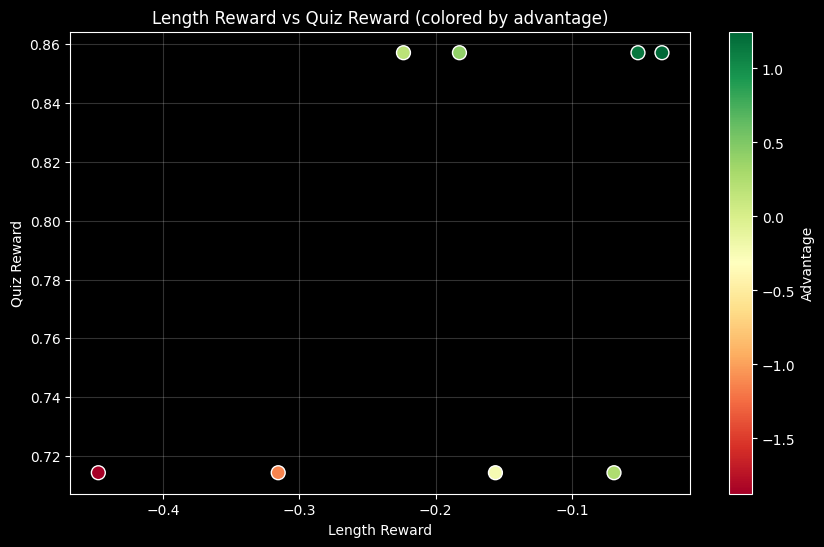

In [14]:
from matplotlib import pyplot as plt

advantages = compute_advantages(total_rewards)
min_adv = min(advantages)
max_adv = max(advantages)

plt.figure(figsize=(10,6), facecolor='black')
plt.style.use('dark_background')
scatter = plt.scatter(length_rewards, quiz_rewards, c=advantages, cmap='RdYlGn', s=100, edgecolor='white', vmin=min_adv, vmax=max_adv)
plt.colorbar(scatter, label='Advantage')
plt.xlabel('Length Reward')
plt.ylabel('Quiz Reward')
plt.title('Length Reward vs Quiz Reward (colored by advantage)')
plt.grid(True, alpha=0.2)
plt.show()